In [ ]:
# default_exp processor

In [ ]:
%load_ext autoreload
%autoreload 2

# cheviz processor

The idea of our processor is to take a game and process it into a useful, annotated format Pandas could consume. This should help with our analysis and later on ML training.

In [ ]:
#export
from typing import Callable
import pandas as pd
import numpy as np
import chess.engine
import cheviz.core as cco
import cheviz.data as cda
import cheviz.stockfish as cst

The [python-chess example](https://python-chess.readthedocs.io/en/latest/engine.html) shows us how to get stockfish to score a given position.

engine score: #+1


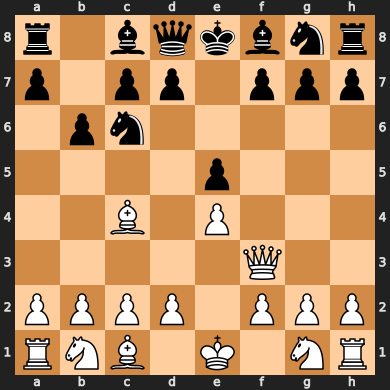

In [ ]:
engine = cst.makeEngine()()
board = chess.Board("r1bqkbnr/p1pp1ppp/1pn5/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR w KQkq - 2 4")
info = engine.analyse(board, chess.engine.Limit(depth=20))
engine.quit()

print('engine score:', info['score'])
display(board)

Let's process the first game from the Candidates tournament 1953.

In [ ]:
games = list(cda.games(cda.fetch()['Candidates_1953.pgn']))
games[0].headers, games[0].moves

(Headers(Event='ct', Site='Zurich', Date='1953.??.??', Round='01', White='Szabo L', Black='Geller E', Result='0-1'),
 <Mainline at 0x7fa434dcb8d0 (1. c4 Nf6 2. g3 e6 3. Bg2 d5 4. d4 dxc4 5. Qa4+ Nbd7 6. Nf3 a6 7. Qxc4 b5 8. Qc6 Rb8 9. Bf4 Nd5 10. Bg5 Be7 11. Bxe7 Qxe7 12. O-O Bb7 13. Qc2 c5 14. dxc5 Nxc5 15. Rc1 Rc8 16. Nc3 Nf6 17. b4 Na4 18. Qb3 Nxc3 19. Rxc3 Rxc3 20. Qxc3 O-O 21. Rc1 Rd8 22. a3 Nd5 23. Qd4 f6 24. Ne1 e5 25. Qc5 Qxc5 26. bxc5 Bc6 27. Rd1 Rd7 28. Bh3 Re7 29. Nc2 a5 30. Bg2 Rd7 31. Bh3 Re7 32. Kf1 Kf7 33. Ke1 Rc7 34. Rd3 Bb7 35. Ne3 Rxc5 36. Nf5 Bc6 37. Nd6+ Kf8 38. Bg2 g6 39. Kd2 Ke7 40. Ne4 Rc4 41. f3 f5 42. Nf2 Ra4 43. Nd1 e4 44. fxe4 fxe4 45. Rb3 Rd4+ 46. Kc1 b4 47. Ne3 Nc3 48. axb4 Nxe2+ 49. Kb1 Ba4 50. Rb2 Nc3+ 51. Kc1 axb4 52. Rd2 Rxd2 53. Kxd2 Kd6 54. Ng4 Kc5 55. h4 Kd4 56. h5 gxh5 57. Ne3 Nb1+ 58. Ke2 Bb5+ 59. Kf2 b3)>)

I still need to figure out how to safely do RAII with Python, hence the clumsy `engine_maker` stuff. Python's `with ... as ...:` looks promising.

In [ ]:
#export
class Processor:
    def __init__(self, engine_maker:Callable, game:cda.Game, first_move_by_white=True):
        self.engine_maker = engine_maker
        self.moves = list(game.moves)
        self.first_move_by_white = first_move_by_white
        self.ms = cda.makeMoveSequencer(self.moves)


    def run(self, reduced:Callable, square_filter:Callable, echo:int=1, depth=20):
        engine = self.engine_maker()
        result = pd.DataFrame(columns=['Side', 'Score',
                                       'LastWhiteMove', 'LastBlackMove',
                                       'ViewForWhite', 'ViewForBlack',
                                       'Zeros'])

        for curr_move in range(len(self.moves)):
            adjusted_wm = (curr_move // 2) * 2 + 1
            adjusted_bm = ((curr_move + 1) // 2) * 2
        
            side = bool((curr_move + 1) % 2) # white: 1, black: 0, same as in python-chess
            if not self.first_move_by_white:
                adjusted_wm, adjusted_bm = adjusted_bm, adjusted_wm # not tested!
            
            last_white_move = self.moves[abs(adjusted_wm - 1)]
            last_black_move = self.moves[abs(adjusted_bm - 1)]
        
            white = self.ms(range(adjusted_wm - echo, adjusted_wm), chess.WHITE, square_filter)
            black = self.ms(range(adjusted_bm - echo, adjusted_bm), chess.BLACK, square_filter)
            reduced_white = reduced(white.result)
            reduced_black = reduced(black.result)
        
            info = engine.analyse(white.board if side else black.board, chess.engine.Limit(depth=depth))
        
            result.loc[curr_move] = ['White' if side else 'Black', info['score'],
                                     last_white_move, last_black_move,
                                     reduced_white, reduced_black,
                                     cda.countZeros(np.logical_or(reduced_white, reduced_black))]

        engine.quit() # This is important, otherwise we leak opened file objects!
        return result

In [ ]:
proc = Processor(cst.makeEngine(), games[0])
data = proc.run(cda.diffReduce, cco.attack, 7)

We now have a dataframe of positions, each analyzed by stockfish.

In [ ]:
data.head(10)

,Side,Score,LastWhiteMove,LastBlackMove,ViewForWhite,ViewForBlack,Zeros
0,White,+54,c2c4,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44
1,Black,+80,c2c4,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",41
2,White,+77,g2g3,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",47
3,Black,+70,g2g3,e7e6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",52
4,White,+71,f1g2,e7e6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48
5,Black,+66,f1g2,d7d5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",45
6,White,+69,d2d4,d7d5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",39
7,Black,+94,d2d4,d5c4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37
8,White,+84,d1a4,d5c4,"[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",33
9,Black,+21,d1a4,b8d7,"[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0...","[0.0, -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",35


Notice that the `ViewFor{White,Black}` only change with every other move. This is intentional.

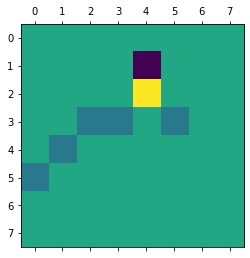

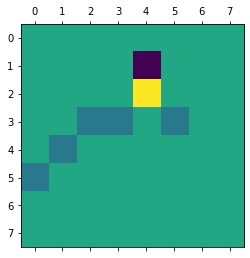

In [ ]:
cco.show(data.loc[3, 'ViewForBlack']), cco.show(data.loc[4, 'ViewForBlack']);

Obviously, we can combine those arrays.

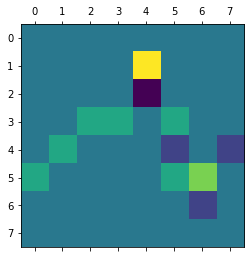

In [ ]:
cco.show(data.loc[3, 'ViewForWhite'] - data.loc[3, 'ViewForBlack']);

We can filter the dataframe by side.

In [ ]:
data[data['Side'] == 'White'].head(5)

,Side,Score,LastWhiteMove,LastBlackMove,ViewForWhite,ViewForBlack,Zeros
0,White,+54,c2c4,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44
2,White,+77,g2g3,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",47
4,White,+71,f1g2,e7e6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48
6,White,+69,d2d4,d7d5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",39
8,White,+84,d1a4,d5c4,"[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",33
